# Exploratory analysis of LIV_PAT_457
The purpose of this notebook to to examine the behavior of ILI tools in the LIV_PAT_457 pipeline.  This pipeline is important because it is in only pipline for which Fortis has data from the Rosen EMAT.

# Preliminaries
### Libraries and file locations

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats

Set parameters for reading speed data from the Excel spreadsheet

In [125]:
data_dir = "../SpeedData"
data_file = "LIV_PAT_457 Velocity Excursion Review.xlsm"
data_sheet = "Event Log & Velocity Listing"
data_cols = [3,6,7,8]
data_skiprows = [0,1,2,3,5]


The following dictionary lists the tools in the data file and defined some degradation parameters (speeds at which the data degrades).

In [126]:
tools = {
    "BHGE_MFL": {
        "degrade": 5,
        "blind": 7},
    "ROSEN_MFL_C": {
        "degrade": 4.5,
        "blind": 7},
    "ROSEN_EMAT": {
        "degrade": 2.5,
        "blind": 4}
    }

### Read the file
The following reads the Excel file into a Pandas dataframe call `pl_raw`.  The dataframe consists of an integer index, a Distance value, and then tool velocity values for each of the three tools.

Duplicates are removed (wherever the distance and velocity of the BHGE_MFL are identical). The `head()` method is called to show the first four values of the resulting dataframe.

In [139]:
pl_raw = pd.read_excel(data_dir + "/" + data_file,
                   sheet_name=data_sheet,
                   usecols=data_cols,
                   names = ["Distance"] + list(tools.keys()),
                   skiprows=data_skiprows)
pl_raw = pl_raw[pl_raw.duplicated(["Distance", "BHGE_MFL"]) != True]
pl_raw.head(4)

,Distance,BHGE_MFL,ROSEN_MFL_C,ROSEN_EMAT
0,0.000,1.171,NaN,NaN
1,0.137,0.954,3.3,0.4
2,0.583,1.048,NaN,NaN
3,1.039,0.882,3.9,0.6


# Test 1: Velocity correlation between tools
The following is a simple visual analysis to determine if the velocities for the three tools are correlated with each other. The code below constructs a pairplot by comparing each pairwise combination of velocities in every row of the dataframe.  Rows in which one or both velocity values are missing are supressed.

If the velocities of the tools are highly correlated, then the velocity of other tools can be used to predict the velocity of the Rosen EMAT.  This would be a useful way to use historical data from other tools in other pipelines to predict the speed of the Rosen EMAT in those same pipelines.

<Figure size 720x720 with 0 Axes>

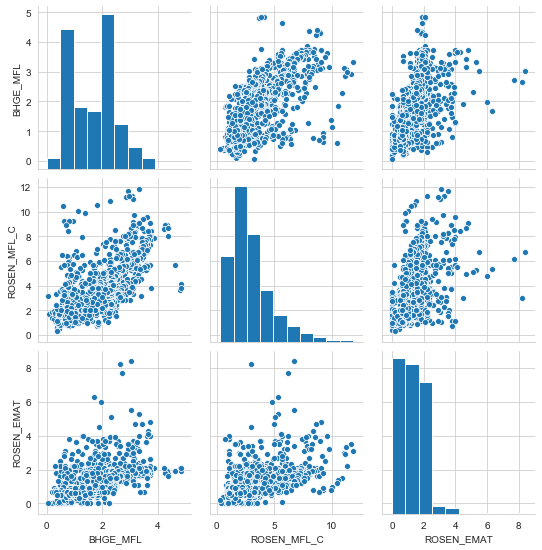

In [140]:
plt.figure(figsize=(10,10))
ax = sns.pairplot(pl_raw.iloc[:, 1:4])
plt.show()

__Conclusion:__ If we focus on the bottom row of the scatterplot matrix, we see that neither the BHGE_MFL nor the ROSEN_MFL_C velocities provide a good prediction of the velocity of the ROSEN_EMAT.  Furthermore, if we examine the histograms along the diagonals, we see a much smaller variance in the velocity of the EMAT.

The correlation matrix (which shows correlation coefficients for each pair of tools) provides numbers for the scatterplots above.

In [141]:
pl_raw.iloc[:, 1:4].corr().round(2)

,BHGE_MFL,ROSEN_MFL_C,ROSEN_EMAT
BHGE_MFL,1.00,0.71,0.61
ROSEN_MFL_C,0.71,1.00,0.55
ROSEN_EMAT,0.61,0.55,1.00


# Test 2: Examination of speed profiles
In this section, the velocity of each tool in the LIV_PAT_457 dataset is plotted against distance.  The purpose of these plots (included the zoomed versions) is to better understand the differences in the velocities of the different tools.

To make this easier using the Seaborn graphics library, we first "unpivot" the data so that it is in long format.

### Unpivot pipeline data

In [142]:
pl = pd.melt(pl_raw,
                id_vars="Distance",
                var_name="Tool",
                value_name="Velocity")
pl["Tool"] = pl["Tool"].astype('category')
pl.head(3)

,Distance,Tool,Velocity
0,0.000,BHGE_MFL,1.171
1,0.137,BHGE_MFL,0.954
2,0.583,BHGE_MFL,1.048


### Plot speed profile

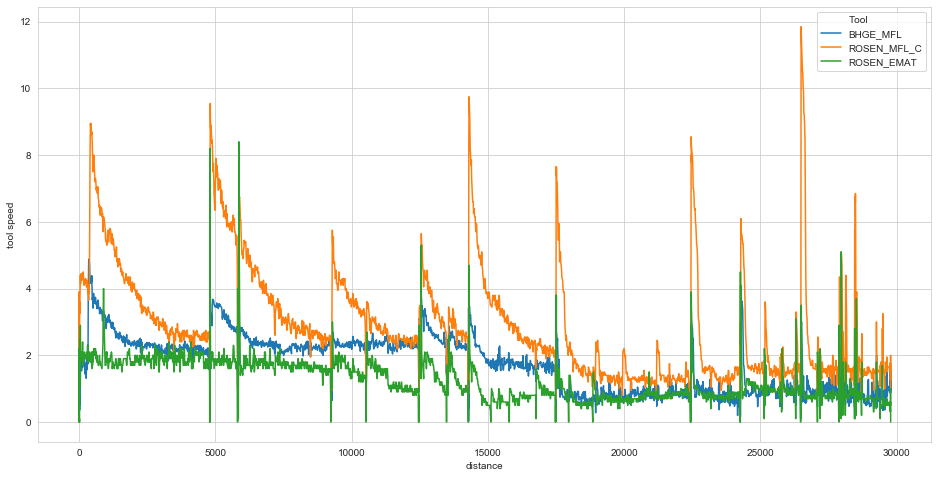

In [143]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="Distance", y="Velocity", hue="Tool", data=pl)
ax.set(xlabel="distance", ylabel="tool speed")
plt.show()

# Test 3: Probability of blindness
In this test, we move away from velocity as the measure of interest and calculate the probability that the tool is blind given the specific tool characteristics and velocity.

To map from tool speed to probability of blindness, we use a transformation based on an S-curve.  Specifically, the probabilty of the tool blindness below the "degrade" threshold velocity defined for each tool is zero.  On the other hand, the probabilty of blindness above the "blind" threshold velocity is 1.0.  An intermediate probability between zero and 1.0 is assigned to velocities between the thresholds.

### Determining the threshold curve
The threshold curve is illustrated below for the Rosen EMAT thresholds.  The cumulative normal distribution function (CDF) is used to provide the mapping between velocity and blindness.  The mean and standard deviation of the normal are derived from the two tool thresholds.

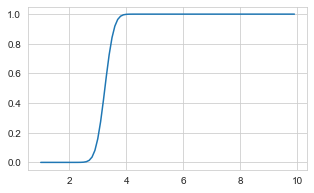

In [154]:
degrade = 2.5
blind = 4
mean = degrade + (blind-degrade)/2
std = (blind-degrade)/6
plt.figure(figsize=(5,3))
sns.set_style("whitegrid")
ax = sns.lineplot(x, norm.cdf(x, loc=mean, scale=std))
plt.show()

### Function to calculate the probability of blindness
We define a function to calculate the probability of blindness given two pieces of information: the name of the tool and its velocity.  This is passed as a Panda series data structure for convenience.  The value of row\[0\] corresponds to the tool name whereas row\[1\] contains the tool's velocity.  This is not a particularly efficient function, but it encapulates all the logic required for the S-curve.

In [145]:
def prob_blind(row):
    mean = tools[row[0]]["degrade"] + (tools[row[0]]["blind"]- tools[row[0]]["degrade"])/2
    std = (tools[row[0]]["blind"]- tools[row[0]]["degrade"])/6
    return norm.cdf(row[1], loc=mean, scale=std)

### Assigning the probabilty of blindness to each each measurement
The assignment below creates a new column called `ProbBlind`.  It uses Python's `apply()` function to pass tool and velocity for each row of the dataframe with a non-null velocity.

In [146]:
pl["ProbBlind"] = pl[~pl["Velocity"].isnull()][["Tool", "Velocity"]].apply(prob_blind, axis=1)

### Plotting the probability of blindness
We plot the probability of blindness below against distance to see whether their is greater correlation between blindness for the different tools.

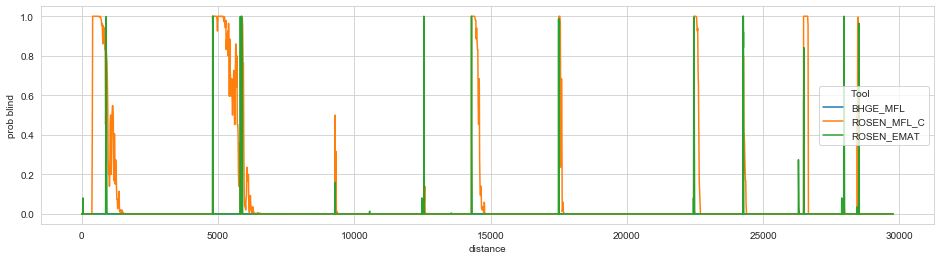

In [153]:
plt.figure(figsize=(16,4))
ax = sns.lineplot(x="Distance", y="ProbBlind", hue="Tool", data=pl)
ax.set(xlabel="distance", ylabel="prob blind")
plt.show()

### Zooming in on blindness and velocity
The next two grapics are zoomed-in versions of the blindness and velocity plots.  The start and end of the zoom can be specified by changing the distances used to define the `pl_zoom` dataframe.

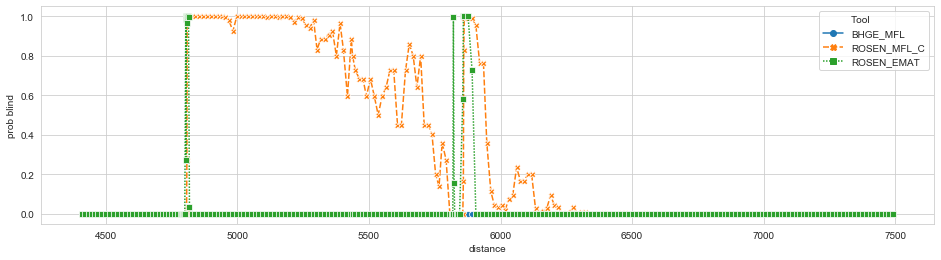

In [152]:
pl_zoom = pl[(pl.Distance > 4400) & (pl.Distance < 7500)]
plt.figure(figsize=(16,4))
ax = sns.lineplot(x="Distance", y="ProbBlind", hue="Tool", style="Tool", markers=True, data=pl_zoom)
ax.set(xlabel="distance", ylabel="prob blind")
plt.show()

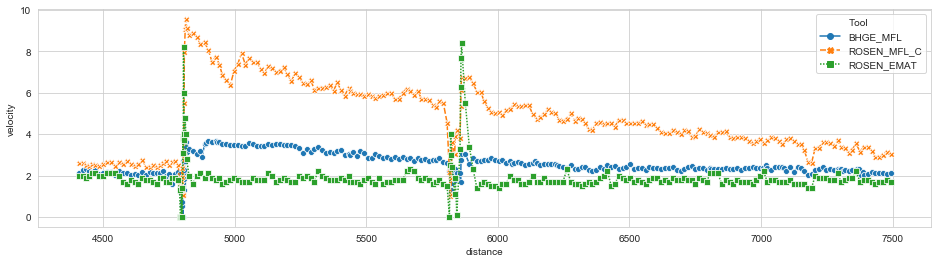

In [151]:
plt.figure(figsize=(16,4))
ax = sns.lineplot(x="Distance", y="Velocity", hue="Tool", style="Tool", markers=True, data=pl_zoom)
ax.set(xlabel="distance", ylabel="velocity")
plt.show()

**Conclusion:** There is even less evidence of corrlation between tools when we look at blindness.  The BHGE tool is never blind in the data set (its speed never exceeds the "degrade" threshold).  This is verified in the dataframe lookup below.

In [150]:
pl[(pl["Tool"] == "BHGE_MFL") & (pl["Velocity"] >= 5)]

,Distance,Tool,Velocity,ProbBlind


In short, blindness of the other two tools is a very poor predictor of blindness for the Rosen EMAT.  This is confirmed by the correlation matrix below.  Note: to use the Pandas `corr()` function, we have to re-pivot the data so that the three tools are column headings.

In [155]:
pl_blind = pl.pivot(index="Distance", columns="Tool", values="ProbBlind")
pl_blind[["ROSEN_EMAT", "ROSEN_MFL_C", "BHGE_MFL"]].corr()

Tool,ROSEN_EMAT,ROSEN_MFL_C,BHGE_MFL
Tool,,,
ROSEN_EMAT,1.000000,0.235803,-0.005452
ROSEN_MFL_C,0.235803,1.000000,-0.009446
BHGE_MFL,-0.005452,-0.009446,1.000000


# Test 4: Speed peaks
On issue that is clear from the probability of blindness analysis is that the Rosen EMAT tool recovers its steady-state speed quicker than the other tools in the dataset.  In this section, we look only at peaks&mdash;that is, the point at which tool speed (a) exceeds a threshold and (b) is the high-point within that speed excursion.  We are primarily interested in the number of peaks and their location in the pipeline.

### Routine to mark speed peaks
The following function marks the peak of speed excursions.  The basic approach is this:
1. Start with a list of rows (for a particular tool) in which velocity exceeds some threshold.  For the EMAT, the threshold is taken as the "degrade" threshold (indicating the onset of a possible blindspot).  For the other tools, the threshold is tunable.
2. For each row, one of two things is is true:
    1. It is part of a new peak&mdash;that is, it is far enough away from the previous peak to be considered different.  This "far enough away" is determined by the variable `dist_thresh`
    2. It is part of the current peak.  The question is thus whether it is a new peak or is slower than the existing peak.

This routine marks each record with a 1 if it is a unique peak and zero otherwise.  It is called in the analysis and tuning routines below.

In [202]:
def mark_excursion(tool, speed_thresh):
    hssegs = pl[(pl["Velocity"] >= speed_thresh) & (pl["Tool"] == tool)]
    if hssegs.index.size != 0:
        peak = {
            "segid": None,
            "velocity": 0
        } # initialize peak holder
        pdist = hssegs.loc[hssegs.first_valid_index(),"Distance"] # starting distance
        for segid in hssegs.index:
            if hssegs.loc[segid, "Distance"] > (pdist + dist_thresh):
                # write new peak
                pl.loc[peak["segid"], "Excursion"] = 1
                peak["segid"] = segid
                peak["velocity"] =  hssegs.loc[segid, "Velocity"]
            else:
                if (hssegs.loc[segid, "Velocity"] > peak["velocity"]):
                    peak["segid"] = segid
                    peak["velocity"] = hssegs.loc[segid, "Velocity"]
            pdist = hssegs.loc[segid, "Distance"]
        pl.loc[peak["segid"], "Excursion"] = 1 
    return

### Mark speed peaks based on degrade thresholds
This is a first cut at matching the other two tools to the speed peaks of the Rosen EMAT. This routine loops through each of the three tools and sets their peak flags.

In [273]:
pl["Excursion"] = 0  # reset column
dist_thresh = 100
for key in tools:
    mark_excursion(key, tools[key]["degrade"])

### Compare peaks based on degrade thresholds
As shown below, the BHGE has no speed peaks at its degrade threshold.  The Rosen MFL-C has fewer than the EMAT.  This can be confirm by examining the stacked graphs or simply counting the peaks for each tool

In [274]:
pl.groupby("Tool")["Excursion"].sum()

Tool
BHGE_MFL        0
ROSEN_EMAT     16
ROSEN_MFL_C    13
Name: Excursion, dtype: int64

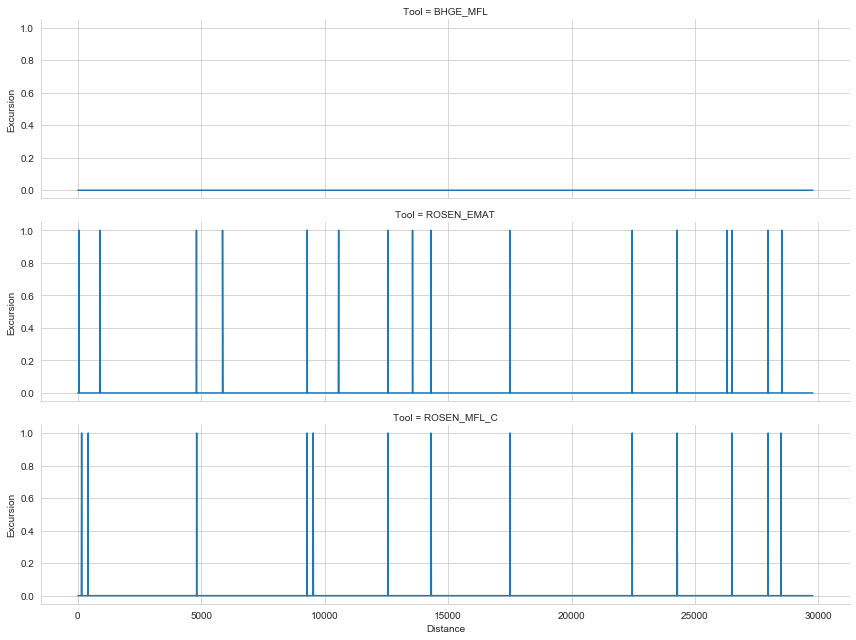

In [275]:
args = ("Distance", "Excursion")
g = sns.FacetGrid(pl, row="Tool", aspect=4)
g.map(sns.lineplot, *args);

### Tuning the peak parameter
The objective here is to find velocity thresholds at which the other two tools predict speed excursions for the EMAT.  the peak for the other two tools is set using a simple trial and error loop and attempting to match the number of peaks to that of the EMAT.

The procedure for using the tuning loop below is as follows:
1. Set the tool
2. Start with a wide range of values for the threshold speed (`i` in the loop).
3. Repeat until an appropriate value is found for each tool
4. Update the `tools` dictionary below with the best value threshold value of each non-EMAT tool

In [287]:
vals = list()
tool = "ROSEN_MFL_C"
#tool = "BHGE_MFL"
for i in np.arange(3.5, 4, .05):
    pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
    mark_excursion(tool, i)
    vals.append((tool, round(i,3), pl.groupby("Tool").get_group(tool)["Excursion"].sum()))
vals


[('ROSEN_MFL_C', 3.5, 15),
 ('ROSEN_MFL_C', 3.55, 16),
 ('ROSEN_MFL_C', 3.6, 15),
 ('ROSEN_MFL_C', 3.65, 13),
 ('ROSEN_MFL_C', 3.7, 16),
 ('ROSEN_MFL_C', 3.75, 15),
 ('ROSEN_MFL_C', 3.8, 15),
 ('ROSEN_MFL_C', 3.85, 14),
 ('ROSEN_MFL_C', 3.9, 12),
 ('ROSEN_MFL_C', 3.95, 12)]

### Storing tool parameters
The following values are used for the remainder of this analysis.  These values should be written to the `Tools` sheet in`Datasets.xlsx` for use in other notebooks.

In [291]:
tools["ROSEN_EMAT"]["peak"] = tools["ROSEN_EMAT"]["degrade"]
tools["BHGE_MFL"]["peak"] = 2.6
tools["ROSEN_MFL_C"]["peak"] = 3.6

### Re-marking peaks using the new speed thresholds 
A new value `peak` is added to the tools dictionary. For the EMAT, the peak threshold is simply the "degrade" threshold.  The peak marking routine is run using these thresholds.

In [292]:
remark_tools = ["ROSEN_MFL_C", "BHGE_MFL"]
for tool in remark_tools:
    pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
    mark_excursion(tool, tools[tool]["peak"])
    print("{} peaks {}".format(tool, pl.groupby("Tool").get_group(tool)["Excursion"].sum()))

ROSEN_MFL_C peaks 15
BHGE_MFL peaks 15


### Comparing the peaks
The graph below shows the peaks given the parameter tuning. Both tools show some correspondence of peak location compared to the EMAT, although the match is not perfect.

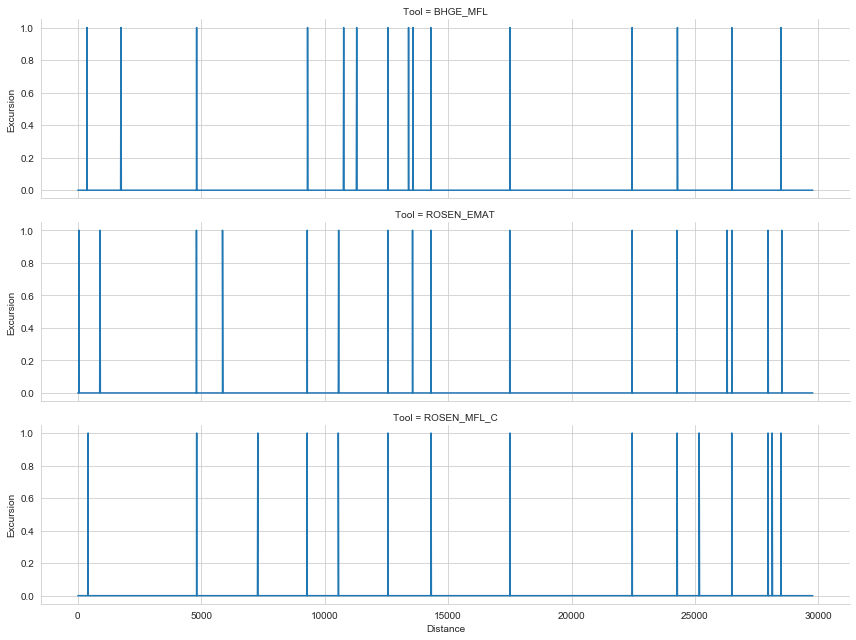

In [293]:
args = ("Distance", "Excursion")
g = sns.FacetGrid(pl, row="Tool", aspect=4)
g.map(sns.lineplot, *args);

In [272]:
pl.groupby("Tool")["Excursion"].sum()

Tool
BHGE_MFL       19
ROSEN_EMAT     19
ROSEN_MFL_C    20
Name: Excursion, dtype: int64

# Conclusions
We can use speed data from the other two tools to predict the number and approximate location of peaks for the Rosen EMAT.  To do this, we parameterize a peak speed threshold for each tool.  Intuitively, this is the speed above which the peaks for the tool most closely match the peaks for the EMAT (which are based on the tool's degrade threshold and thus likely correspond to blindspots).

# Distribution of peaks

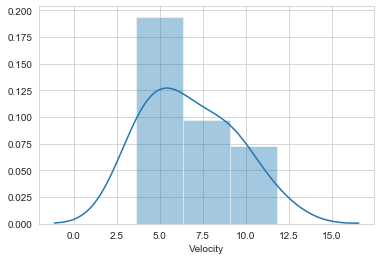

In [296]:
sns.distplot(pl[(pl["Tool"] == "ROSEN_MFL_C") & (pl["Excursion"] == 1)]["Velocity"])